# Histopathologic Cancer Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

## Downloading Image Dataset

In a terminal, run the following command:

**Source:** https://www.kaggle.com/c/histopathologic-cancer-detection/data

```shell
kaggle competitions download -c histopathologic-cancer-detection
```

This downloads the `histopathologic-cancer-detection` dataset with `train` and `test` images in their respective directories. Each train image has an `image id` and a `label` specified in `train_labels.csv`.

File structure:

```txt
histopathologic-cancer-detection/
├── test/
│   └── img_1_test.tif
├── train/
│   └── img_1_train.tif
└── train_labels.csv

```

## Explore Dataset

In [2]:
DATA_DIR = Path.home() / 'Downloads' / 'histopathologic-cancer-detection'

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
LABELS_PATH = DATA_DIR / 'train_labels.csv'

In [3]:
def count_files(path, file_type: str) -> int:
    num_files = len(list(Path(path).glob(file_type)))
    return num_files

In [4]:
print(f'Number of Train Images: {count_files(TRAIN_DIR, "*.tif")}')
print(f'Number of Test Images: {count_files(TEST_DIR, "*.tif")}') 

Number of Train Images: 220025
Number of Test Images: 57458


### Examine Training Data

In [5]:
# get list of image file names
train_image_paths = list(Path(TRAIN_DIR).glob('*.tif'))

# observe the first 5 image names
print(f'Sample of Train Images:\n')
for i in train_image_paths[:5]:
    print(i.stem + i.suffix)

Sample of Train Images:

1d4434f36f4068a95df114b09b87299a026ea780.tif
17b17187e3858fa0aa5414d9712ce0dc959b7f9c.tif
dfd2afa456460108f9306c60831cd53da7edd304.tif
7426e502f6748c0299d8d80c1c28295014e07013.tif
b51d90692dc4572493745d92a496d59b88639cc7.tif


In [6]:
# observe train image labels
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv')

train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Training Class Balance

Label 0: 59.50 %
Label 1: 40.50 %


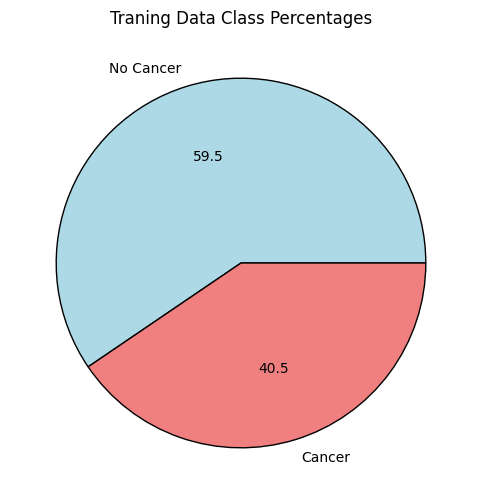

In [7]:
# examine training data's class balance
train_labels_counts = train_labels.label.value_counts()

print(f'Label 0: {train_labels_counts[0] / len(train_labels) * 100:.2f} %')
print(f'Label 1: {train_labels_counts[1] / len(train_labels) * 100:.2f} %')

plt.figure(figsize=(6, 6))
plt.pie(train_labels_counts,
        labels=['No Cancer', 'Cancer'],
        startangle=0, colors=['lightblue', 'lightcoral'],
        autopct='%1.1f',
        wedgeprops={'edgecolor': 'black',
                    'linewidth': 1})
plt.title('Traning Data Class Percentages')
plt.show()


### Observe Sample of Training Images

In [8]:
def view_sample_images(train_dir, file_type: str, train_labels_dir, rows=2, n=16, cols=16//2, seed=4):
    # adjust random seed as you see fit
    np.random.seed(seed)

    train_image_paths = list(Path(train_dir).glob(f'*.{file_type}'))
    df_labels = pd.read_csv(train_labels_dir)

    # get n random samples
    samples = np.random.choice(train_image_paths, n)
    print(len(samples))

    # display samples
    plt.figure(figsize=(14, 4))
    for i, img_path in enumerate(samples):
        with Image.open(img_path) as f:
            # get image label
            label = df_labels.loc[df_labels['id'] == img_path.stem, 'label'].values[0]

            plt.subplot(rows, cols, i+1)
            plt.imshow(f)
            plt.title(f'Label: {label}')
            plt.axis(False)

16


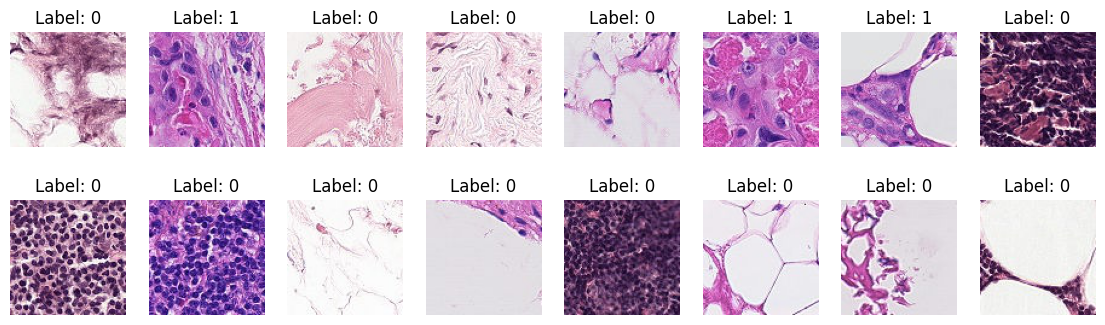

In [9]:
view_sample_images(TRAIN_DIR, 'tif', LABELS_PATH)

## Data Preprocessing

The default dataset does not have available labels for images in *Test* directory. To have a test set with labels so that we can evaluate our model's performance on unseen data, we will partition a subset of the training data. Thus, the images in *Test* directory from the original download will not be used.